In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


df=pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Pessoal/Documentos/LabMol/SOFIA/MQ/Paper OdorSight/DATA/Curation/curated_dataset_final.csv')
x=df[['SMILES']]
y=df[['Outcome']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, random_state=42, stratify=y)


In [8]:
# 2. Gerar fingerprints MACCS para treino e teste
molecules_train = [Chem.MolFromSmiles(smile) for smile in X_train['SMILES']]
fingerprints_train = [MACCSkeys.GenMACCSKeys(mol) for mol in molecules_train]

molecules_test = [Chem.MolFromSmiles(smile) for smile in X_test['SMILES']]
fingerprints_test = [MACCSkeys.GenMACCSKeys(mol) for mol in molecules_test]

print(f"Fingerprints treino: {len(fingerprints_train)}")
print(f"Fingerprints teste: {len(fingerprints_test)}")


Fingerprints treino: 3407
Fingerprints teste: 852


In [9]:
# 3. Calcular a similaridade máxima de cada molécula de teste com o conjunto de treino
max_similarities = []

for test_fp in tqdm(fingerprints_test, desc="Calculando similaridades teste vs treino"):
    # Calcula a similaridade com todos os compostos do treino
    similarities = [DataStructs.DiceSimilarity(test_fp, train_fp) for train_fp in fingerprints_train]
    max_sim = max(similarities)  # Encontra a similaridade máxima com o treino
    max_similarities.append(max_sim)

max_similarities = np.array(max_similarities)

# 4. O threshold é o MENOR valor de similaridade entre teste e treino
threshold = np.min(max_similarities)

print(f"\n{'='*60}")
print(f"THRESHOLD DO DOMÍNIO DE APLICABILIDADE")
print(f"{'='*60}")
print(f"Menor similaridade (teste vs treino): {threshold:.4f}")
print(f"\nEstatísticas das similaridades máximas:")
print(f"  - Média: {np.mean(max_similarities):.4f}")
print(f"  - Mediana: {np.median(max_similarities):.4f}")
print(f"  - Desvio Padrão: {np.std(max_similarities):.4f}")
print(f"  - Mínimo: {np.min(max_similarities):.4f}")
print(f"  - Máximo: {np.max(max_similarities):.4f}")
print(f"{'='*60}")


Calculando similaridades teste vs treino: 100%|██████████| 852/852 [00:03<00:00, 227.69it/s]


THRESHOLD DO DOMÍNIO DE APLICABILIDADE
Menor similaridade (teste vs treino): 0.4615

Estatísticas das similaridades máximas:
  - Média: 0.9283
  - Mediana: 0.9474
  - Desvio Padrão: 0.0743
  - Mínimo: 0.4615
  - Máximo: 1.0000


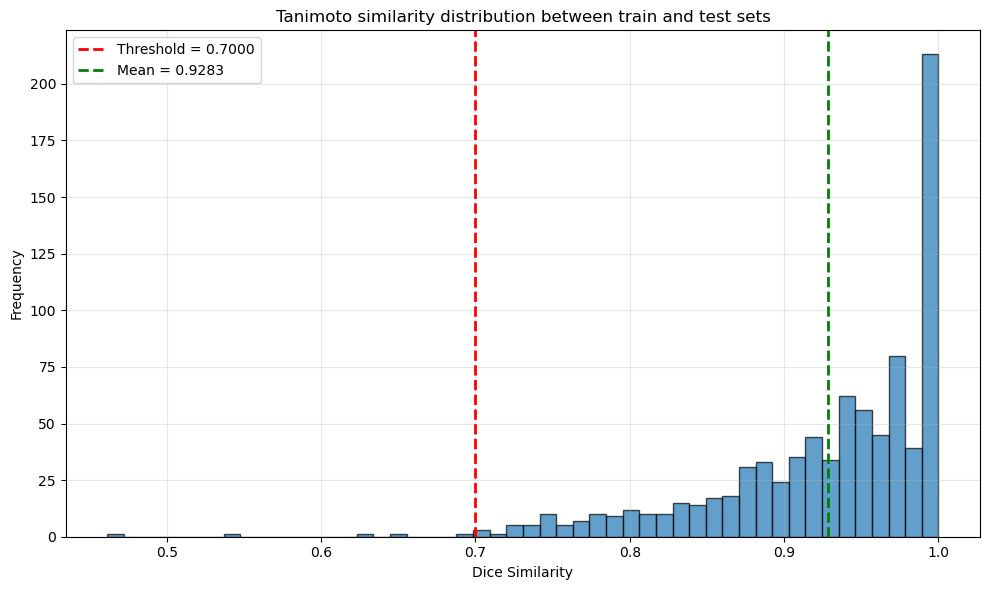


99.41% dos compostos de teste estão dentro do domínio de aplicabilidade
(847/852 compostos)


In [ ]:
# 5. Visualizar a distribuição das similaridades máximas
threshold = 0.70

plt.figure(figsize=(10, 6))
plt.hist(max_similarities, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, 
            label=f'Threshold = {threshold:.4f}')
plt.axvline(np.mean(max_similarities), color='green', linestyle='dashed', linewidth=2, 
            label=f'Mean = {np.mean(max_similarities):.4f}')
plt.title('Dice similarity distribution between train and test sets')
plt.xlabel('Dice Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Calcular porcentagem de compostos dentro do domínio
within_domain = np.sum(max_similarities >= threshold)
percentage_within = (within_domain / len(max_similarities)) * 100

print(f"\n{percentage_within:.2f}% dos compostos de teste estão dentro do domínio de aplicabilidade")
print(f"({within_domain}/{len(max_similarities)} compostos)")


In [11]:
max_similarities

array([1.        , 0.95833333, 1.        , 1.        , 1.        ,
       0.46153846, 1.        , 1.        , 0.91891892, 0.82926829,
       1.        , 0.90322581, 1.        , 1.        , 0.83018868,
       0.93023256, 0.95454545, 1.        , 0.88235294, 0.87804878,
       1.        , 0.93617021, 0.97959184, 1.        , 0.93333333,
       0.97435897, 0.95652174, 0.95454545, 0.97297297, 0.97297297,
       0.91428571, 1.        , 0.7826087 , 0.95238095, 0.90265487,
       0.75      , 0.85714286, 0.65217391, 0.9787234 , 1.        ,
       0.98039216, 0.92682927, 0.95652174, 1.        , 0.9047619 ,
       0.95081967, 0.97142857, 0.90909091, 1.        , 0.90909091,
       0.94915254, 0.79166667, 0.94623656, 1.        , 0.84210526,
       0.97142857, 1.        , 0.87179487, 0.97560976, 0.95      ,
       0.88461538, 0.92592593, 1.        , 0.92307692, 0.90909091,
       0.94545455, 1.        , 0.88461538, 0.97959184, 0.97959184,
       1.        , 0.95      , 0.96774194, 0.98245614, 1.     

In [13]:
df_similarity = pd.DataFrame(max_similarities, columns=['Max_Similarity'])
df_similarity.to_excel('similarity_results.xlsx', index=False)